![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import collections
from datetime import datetime
import re

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# Сброс ограничений на количество выводимых рядов
pd.set_option("display.max_rows", 250)

# Сброс ограничений на число столбцов
pd.set_option("display.max_columns", 250)

# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', 250)



In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]",/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]",/Restaurant_Review-g189852-d7992032-Reviews-Buddha_Nepal-Stockholm.html,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'], ['01/08/2018', '01/06/2018']]",/Restaurant_Review-g186338-d8632781-Reviews-ROKA_Mayfair-London_England.html,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Esplanade-Berlin.html,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Friendly']",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice building but improvements need to be...'], ['11/18/2017', '02/19/2017']]",/Restaurant_Review-g187309-d6864963-Reviews-Augustiner_Schutzen_Garten-Munich_Upper_Bavaria_Bavaria.html,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]",/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/28/2017', '12/06/2017']]",/Restaurant_Review-g186525-d13129638-Reviews-Black_Ivy-Edinburgh_Scotland.html,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vegetarian Friendly', 'Gluten Free Options']",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic'], ['12/06/2017', '11/22/2017']]",/Restaurant_Review-g186338-d680417-Reviews-Quirinale-London_England.html,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seafood', 'Vegetarian Friendly', 'Gluten Free Options']",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good but pricey'], ['02/08/2018', '01/24/2018']]",/Restaurant_Review-g274924-d1112354-Reviews-Massimo_Ristorante-Bratislava_Bratislava_Region.html,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
14832,id_756,Prague,"['European', 'Czech', 'Eastern European', 'Central European']",757.0,$$ - $$$,419.0,"[['Very good local cuisine and service', 'Good food and warm cosy ambience'], ['01/08/2018', '01/03/2018']]",/Restaurant_Review-g274707-d1883975-Reviews-Stara_Praha-Prague_Bohemia.html,d1883975,1,4.0
15025,id_9120,Paris,['Chinese'],9122.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d11671339-Reviews-Restaurant_J_V-Paris_Ile_de_France.html,d11671339,1,4.5
26129,id_7625,London,"['Asian', 'Vietnamese', 'Soups', 'Vegetarian Friendly', 'Vegan Options']",7634.0,$,14.0,"[['Secret and amazing', 'Delicious and nice lady'], ['08/14/2017', '08/03/2017']]",/Restaurant_Review-g186338-d8427858-Reviews-Hoa_Phuong-London_England.html,d8427858,1,5.0
22804,id_171,Vienna,"['German', 'Austrian', 'Cafe', 'European', 'Central European', 'Vegetarian Friendly']",172.0,$$ - $$$,232.0,"[['Very nice place, great Austrian cuisine, f...', 'excellent wiener schnitzel'], ['12/25/2017', '09/06/2017']]",/Restaurant_Review-g190454-d1899996-Reviews-Cafe_Englander-Vienna.html,d1899996,1,4.0
23642,id_7471,Paris,"['Chinese', 'Asian', 'Thai', 'Vietnamese']",7472.0,$$ - $$$,96.0,"[['Be vaut pas la peine', 'Hit and miss. Will not be back'], ['02/10/2017', '12/18/2016']]",/Restaurant_Review-g187147-d4782392-Reviews-Guo_Min_Paris-Paris_Ile_de_France.html,d4782392,1,3.5


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [15]:
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

In [16]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

# Остальные столбцы с пропусками
data['Cuisine_Style_isNan'] = pd.isna(data['Cuisine Style']).astype('uint8')
data['Price_Range_isNan'] = pd.isna(data['Price Range']).astype('uint8')
data['Reviews_isNan'] = pd.isna(data['Reviews']).astype('uint8')


#### Reviews

In [17]:
data['Reviews'].value_counts()

[[], []]                                                                                                                              8112
[['Absolutely authentic and delicious!', 'Wonderful discovery'], ['09/30/2017', '08/04/2016']]                                           2
[['Whenever in Madrid, we never miss this gem...', 'Underrated sushi restaurant with very good...'], ['04/11/2017', '12/02/2016']]       2
[['ok for beer, not for dinner'], ['12/20/2017']]                                                                                        2
[['Visited the rooftop bar', 'SIXTH FLOOR ROOFTOP BUT YOU CAN ONLY SEE O...'], ['06/27/2017', '10/31/2017']]                             2
                                                                                                                                      ... 
[['Good coffee', 'Cheap and cheerful'], ['12/14/2017', '04/27/2017']]                                                                    1
[['Friendly Staff & Delicio

In [18]:
# Заменим на пустое значение [[], []]  -  наиболее часто встречающееся (к тому же пропусков мало - всего 2)
data['Reviews'].fillna('[[], []]', inplace=True)


#### Number of Reviews

In [19]:
round(data.groupby(['City'])['Number of Reviews'].mean(), 0)

City
Amsterdam     149.0
Athens         94.0
Barcelona     136.0
Berlin         64.0
Bratislava     52.0
Brussels       93.0
Budapest      159.0
Copenhagen     95.0
Dublin        154.0
Edinburgh     238.0
Geneva         62.0
Hamburg        45.0
Helsinki       66.0
Krakow        131.0
Lisbon        128.0
Ljubljana      88.0
London        138.0
Luxembourg     83.0
Lyon           87.0
Madrid        100.0
Milan         168.0
Munich         78.0
Oporto        134.0
Oslo          100.0
Paris         117.0
Prague        124.0
Rome          290.0
Stockholm      75.0
Vienna         81.0
Warsaw         67.0
Zurich         73.0
Name: Number of Reviews, dtype: float64

In [20]:
data.groupby(['City']).agg({'Number of Reviews': ['count', 'mean', 'min', 'max']}).round(0)


Number of Reviews                    
                       count   mean  min     max
City                                            
Amsterdam               1303  149.0  2.0  6777.0
Athens                   721   94.0  2.0  4234.0
Barcelona               3165  136.0  2.0  4996.0
Berlin                  2445   64.0  2.0  2572.0
Bratislava               323   52.0  2.0  2578.0
Brussels                1230   93.0  2.0  6437.0
Budapest                 935  159.0  2.0  7575.0
Copenhagen               775   95.0  2.0  3426.0
Dublin                   796  154.0  2.0  3491.0
Edinburgh                724  238.0  2.0  4567.0
Geneva                   548   62.0  2.0  1624.0
Hamburg                 1078   45.0  2.0   845.0
Helsinki                 447   66.0  2.0  1488.0
Krakow                   518  131.0  2.0  4608.0
Lisbon                  1536  128.0  2.0  3404.0
Ljubljana                207   88.0  2.0  2006.0
London                  6768  138.0  2.0  9660.0
Luxembourg               250   83.0  2.0   652.0
Lyon                    1079   87.0  2.0  1953.0
Madrid                  3575  100.0  2.0  6013.0
Milan                   2563  168.0  2.0  6360.0
Munich                  1061   78.0  2.0  4694.0
Oporto                   599  134.0  2.0  3206.0
Oslo                     466  100.0  2.0  1391.0
Paris                   5817  117.0  2.0  7622.0
Prague                  1607  124.0  2.0  4521.0
Rome                    2513  290.0  2.0  8927.0
Stockholm                952   75.0  2.0  1461.0
Vienna                  1325   81.0  2.0  4937.0
Warsaw                   829   67.0  2.0  2356.0
Zurich                   645   73.0  2.0  1974.0

In [21]:
# data['Number_of_Reviews_isNAN']
# Далее можно заполнить пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
# data['Number of Reviews'].fillna(0, inplace=True)

In [22]:
len(data[(data['Reviews'] == '[[], []]') & (data['Number of Reviews'].isna())])

# data[(data['Reviews'] != '[[], []]') & (data['Number of Reviews'].isna())].sample(10)

2024

In [23]:
# Заполним 
# 0 - если нет отзывов (Reviews пусто), и 1 - если отзыв есть
# 1176 строк заменим на 1 - непустые отзывы 
# в такой выборке - представлено по  1 отзыву в столбце Reviews, и  в таблице нет 1, min значение 2
# 2024 строк заменим на 0 - пустые отзывы

data.loc[(data['Reviews'] == '[[], []]') & (data['Number of Reviews'].isna()), 
         'Number of Reviews'] = 0
data.loc[(data['Reviews'] != '[[], []]') & (data['Number of Reviews'].isna()), 
         'Number of Reviews'] = 1

In [24]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan
40386,id_4069,Barcelona,NaN,4070.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187497-d12242670-Reviews-Pastisseria_Lis-Barcelona_Catalonia.html,d12242670,1,4.5,0,1,1,0
20074,id_2122,Warsaw,NaN,2123.0,NaN,4.0,"[[], []]",/Restaurant_Review-g274856-d10134516-Reviews-Pizza_Hut-Warsaw_Mazovia_Province_Central_Poland.html,d10134516,1,2.0,0,1,1,0
31756,id_4878,Milan,"['Italian', 'Seafood']",4881.0,$$$$,5.0,"[[], []]",/Restaurant_Review-g187849-d8512079-Reviews-Ristorante_Remi_Berton-Milan_Lombardy.html,d8512079,1,4.0,0,0,0,0
45922,id_16192,London,NaN,16204.0,NaN,216.0,"[['Horrific', 'Most awful place ever - trust everyone tha...'], ['12/23/2017', '12/09/2017']]",/Restaurant_Review-g186338-d733520-Reviews-Cargo-London_England.html,d733520,1,1.5,0,1,1,0
1649,id_1649,Berlin,NaN,5148.0,NaN,2.0,"[['Friendly Alternative Vegan'], ['09/19/2015']]",/Restaurant_Review-g187323-d8650810-Reviews-Wilder_Hase-Berlin.html,d8650810,0,0.0,0,1,1,0


#### Cuisine_Style

In [25]:
# Заменим пропуски на unknown
data['Cuisine Style'] = data['Cuisine Style'].fillna("['unknown']")

In [26]:
# Преобразую в список 
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: str(x)[2:-2])
data['Cuisine Style'] = data['Cuisine Style'].map(lambda x: list(x.split("', '")))

# Посчитаем количество кухонь, в новый столбец данные доюавлю
data['Number_of_Cuisine'] = data['Cuisine Style'].apply(lambda x: len(x))

In [27]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine
4530,id_4530,Paris,"[French, Bar]",13187.0,$$ - $$$,465.0,"[['Paying for location', 'Tipical tourist trap!'], ['10/30/2017', '10/04/2017']]",/Restaurant_Review-g187147-d2692627-Reviews-Unisex-Paris_Ile_de_France.html,d2692627,0,0.0,0,0,0,0,2
8181,id_8181,Milan,[Italian],2527.0,$$ - $$$,250.0,"[['Average', 'GOOD QUALITY TRADITIONAL ITALIAN'], ['06/01/2017', '04/12/2017']]",/Restaurant_Review-g187849-d2272418-Reviews-Al_Vecchio_Porco-Milan_Lombardy.html,d2272418,0,0.0,0,0,0,0,1
44491,id_12486,Paris,[Middle Eastern],12488.0,NaN,4.0,"[[], []]",/Restaurant_Review-g187147-d4602481-Reviews-Le_Relais_d_Or-Paris_Ile_de_France.html,d4602481,1,3.0,0,0,1,0,1
22335,id_3516,Barcelona,[unknown],3517.0,NaN,6.0,"[['Great little cafe/restaurant', 'Fresh, delicious, authentic'], ['01/03/2017', '03/23/2016']]",/Restaurant_Review-g187497-d10096430-Reviews-Cafe_Padilla-Barcelona_Catalonia.html,d10096430,1,5.0,0,1,1,0,1
39782,id_1817,Stockholm,[unknown],1820.0,NaN,11.0,"[['Pleasant'], ['08/27/2016']]",/Restaurant_Review-g189852-d8475937-Reviews-Vintervikens-Stockholm.html,d8475937,1,3.5,0,1,1,0,1


In [28]:
cuisine_list = []
for some in data['Cuisine Style']:
    for Cuisine in some:
        cuisine_list.append(Cuisine)
cuisine_list

c = collections.Counter()
for cuisine in cuisine_list:
    c[cuisine] +=1
    
# print(c)

c.most_common(15)

[('Vegetarian Friendly', 14021),
 ('European', 12561),
 ('unknown', 11590),
 ('Mediterranean', 7820),
 ('Italian', 7433),
 ('Vegan Options', 5684),
 ('Gluten Free Options', 5185),
 ('Bar', 4094),
 ('French', 3970),
 ('Asian', 3786),
 ('Pizza', 3502),
 ('Spanish', 3456),
 ('Pub', 3058),
 ('Cafe', 2883),
 ('Fast Food', 2122)]

В данной графе встречаются несколько разновидностей обозначения кухонь
* названия стилей кухонь (так скажем национальности), 
* тип заведения (кафе, бар, паб,  и тп), 
* разновидности блюд: пицца,суши, суп
* способы приготовления (Гриль, барбекю, 
* Fast Food
* дополнительные опции (Vegetarian Friendly, Vegan Options, Gluten Free Options и тп). Кстати 3 перечисленных входят в 7 наиболее часто встречающихся - тренд/мода на доровое питание - наличие этих опций может повлиять на рейтинг и/или ранкинг ресторана.

Следует повнимательное проанализировать содержание столбца (например, объединить European и Central European), возможно разделить на предложенные категории и поработать с ними отдельно, выявить закономерности.

In [29]:
# Добавлю столбец - доп. опции "healthy_options" (1 или 0)
data['healthy_options'] = data['Cuisine Style'].apply(lambda x: 1 if 'Vegetarian Friendly' in x 
                                                      or 'Vegan Options' in x 
                                                      or 'Healthy' in x 
                                                      or 'Gluten Free Options' in x 
                                                      else 0)

In [30]:
#### 
# from sklearn.preprocessing import MultiLabelBinarizer
# multilabelbinarizer = MultiLabelBinarizer()

# # Создадаим переменные для кухонь, которые встречаются в Датасете
# multilabel_encoded_results = multilabelbinarizer.fit_transform(data['Cuisine Style'])
# # Конвертируем Numpy Array в датафрейм pandas
# df_multilabel_data = pd.DataFrame(multilabel_encoded_results, columns=multilabelbinarizer.classes_)
# # Добавляем полученные классы к датафрейму
# data = pd.concat([data, df_multilabel_data], axis=1)

In [31]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options
43774,id_1060,Dublin,"[Irish, European, Gluten Free Options, Vegetarian Friendly]",1062.0,$$ - $$$,90.0,"[['Nice breakfast', 'Poor and unfriendly service, below average...'], ['07/16/2017', '10/11/2017']]",/Restaurant_Review-g186605-d779037-Reviews-Howards_Way-Dublin_County_Dublin.html,d779037,1,4.0,0,0,0,0,4,1
15137,id_3236,Barcelona,"[Sushi, Asian]",3237.0,$$ - $$$,38.0,"[['Very good and fast', 'Average'], ['12/10/2016', '09/06/2016']]",/Restaurant_Review-g187497-d5862836-Reviews-Kwai_Kwai-Barcelona_Catalonia.html,d5862836,1,4.0,0,0,0,0,2,0
32682,id_2800,Amsterdam,[unknown],2807.0,NaN,3.0,"[['Only stopped by to window shop', 'Ummm, different and interesting'], ['12/18/2017', '11/05/2017']]",/Restaurant_Review-g188590-d13114158-Reviews-Febo_Amsterdam-Amsterdam_North_Holland_Province.html,d13114158,1,3.5,0,1,1,0,1,0
21525,id_7623,Barcelona,"[Seafood, Spanish, Mediterranean, European, Central European]",7624.0,$$$$,27.0,"[['nightmare restaurant', 'aweful sea food full of preservative flavo...'], ['08/16/2017', '08/16/2017']]",/Restaurant_Review-g187497-d12232232-Reviews-Hello_Star-Barcelona_Catalonia.html,d12232232,1,4.0,0,0,0,0,5,0
7974,id_7974,Munich,[unknown],2162.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187309-d9562053-Reviews-Romans-Munich_Upper_Bavaria_Bavaria.html,d9562053,0,0.0,0,1,1,0,1,0


#### Price Range

In [32]:
data['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

In [33]:
# data['Price Range'] = data['Price Range'].apply(lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' 
#                                                 else 3 if x == '$$$$' else x)


# Заменим незаполненные на моду (2) - средний чек в ресторане 
# 17361 - хотя достаточно много пустых 
# data['Price Range'].fillna(2, inplace=True)

In [34]:
# sns.countplot(x='Price Range', data=data, label='Price Range')

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

In [35]:
# ИЛИ можно попробовать One-Hot Encoding? 
# 17361 - достаточно много пустых - ввести значение unknown
# тогда не будет смысла в последовательных числах и можно попробовать dummy переменные

# data['Price Range'].fillna('unknown', inplace=True)
data = pd.get_dummies(data, columns=['Price Range'], dummy_na=False)

In [36]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$
17304,id_3662,Rome,"[Japanese, Fusion]",3663.0,39.0,"[['Good Japanese food'], ['08/20/2017']]",/Restaurant_Review-g187791-d10818482-Reviews-Yado_Sushi-Rome_Lazio.html,d10818482,1,4.0,0,0,0,0,2,0,0,1,0
35170,id_6247,Paris,[unknown],6248.0,9.0,"[['La Felicita / Paris', 'Perfection in an one and unforgettable exp...'], ['02/02/2017', '09/09/2016']]",/Restaurant_Review-g187147-d10758651-Reviews-FELICITA-Paris_Ile_de_France.html,d10758651,1,5.0,0,1,1,0,1,0,0,0,0
20693,id_4099,Rome,"[Italian, Street Food]",4100.0,21.0,"[[], []]",/Restaurant_Review-g187791-d10809766-Reviews-Montefeltro_Gourmet-Rome_Lazio.html,d10809766,1,5.0,0,0,0,0,2,0,1,0,0
45263,id_3708,Prague,[Street Food],3717.0,0.0,"[[], []]",/Restaurant_Review-g274707-d12435635-Reviews-Smichovske_uzeniny_Kratochvil-Prague_Bohemia.html,d12435635,1,3.0,1,0,1,0,1,0,0,0,0
30644,id_2000,Munich,[unknown],2016.0,7.0,"[['Tasty burger for a good price', 'Excellent homemade burgers'], ['07/31/2017', '06/16/2017']]",/Restaurant_Review-g187309-d12230631-Reviews-Ruff_s_Burger-Munich_Upper_Bavaria_Bavaria.html,d12230631,1,4.0,0,1,1,0,1,0,0,0,0


### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

#### Restaurant_id

In [37]:
data['Restaurant_id'].describe()

count      50000
unique     13094
top       id_227
freq          19
Name: Restaurant_id, dtype: object

In [38]:
data['Restaurant_id'].value_counts().head(10)

id_227    19
id_871    19
id_436    19
id_633    19
id_71     18
id_344    18
id_534    18
id_585    18
id_430    18
id_321    18
Name: Restaurant_id, dtype: int64

In [39]:
data[data['Restaurant_id'] == 'id_344']

,Restaurant_id,City,Cuisine Style,Ranking,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$
344,id_344,Amsterdam,"[Vegetarian Friendly, Vegan Options]",1042.0,138.0,"[['A taste of the Maghreb!', 'YUMMY AND YUMMY!'], ['12/18/2017', '12/14/2017']]",/Restaurant_Review-g188590-d875450-Reviews-Rainarai-Amsterdam_North_Holland_Province.html,d875450,0,0.0,0,0,0,0,2,1,0,1,0
10588,id_344,Milan,"[Italian, Pizza, Mediterranean, Vegetarian Friendly, Vegan Options]",345.0,732.0,"[['Salad and pizza', 'Family lunch with friends'], ['09/29/2017', '05/28/2017']]",/Restaurant_Review-g187849-d2648160-Reviews-Pizzeria_di_Porta_Garibaldi-Milan_Lombardy.html,d2648160,1,4.0,0,0,0,0,5,1,0,1,0
11033,id_344,Ljubljana,[unknown],345.0,9.0,"[['Great view with a sweet taste', 'Best view in BTC shopping center'], ['02/27/2017', '03/30/2016']]",/Restaurant_Review-g274873-d7939547-Reviews-Twenty_Caffe-Ljubljana_Upper_Carniola_Region.html,d7939547,1,4.0,0,1,1,0,1,0,0,0,0
13689,id_344,Warsaw,"[Cafe, European, Healthy, Vegetarian Friendly, Vegan Options]",345.0,52.0,"[['Great cafe!', 'very nice place in the centre'], ['11/25/2017', '08/03/2017']]",/Restaurant_Review-g274856-d5603846-Reviews-Niezle_Ziolko-Warsaw_Mazovia_Province_Central_Poland.html,d5603846,1,4.5,0,0,0,0,5,1,0,1,0
15835,id_344,Vienna,"[Italian, Pizza, Mediterranean, European, Vegetarian Friendly, Vegan Options]",345.0,165.0,"[['Good food', 'Nice Italian resto'], ['12/29/2017', '07/24/2017']]",/Restaurant_Review-g190454-d10063696-Reviews-Da_Ferdinando-Vienna.html,d10063696,1,4.0,0,0,0,0,6,1,0,1,0
17414,id_344,London,"[American, Bar, Hawaiian, Vegetarian Friendly, Vegan Options]",345.0,796.0,"[['always love it', 'Best'], ['01/04/2018', '01/03/2018']]",/Restaurant_Review-g186338-d2140493-Reviews-Kua_Aina_Carnaby_Street-London_England.html,d2140493,1,4.5,0,0,0,0,5,1,0,1,0
18363,id_344,Copenhagen,"[Scandinavian, Danish, Vegetarian Friendly]",345.0,87.0,"[['Lovely Lunch', 'Traditional at its best !!!'], ['05/22/2017', '04/16/2017']]",/Restaurant_Review-g189541-d7211256-Reviews-Akvavitten-Copenhagen_Zealand.html,d7211256,1,4.5,0,0,0,0,3,1,0,1,0
22997,id_344,Hamburg,"[German, European, Seafood, Central European, Vegetarian Friendly]",345.0,64.0,"[['Good value fish restaurant', 'A small swimming romantic place'], ['05/14/2017', '04/01/2017']]",/Restaurant_Review-g187331-d1038847-Reviews-Dubelsbrucker_Kajut-Hamburg.html,d1038847,1,4.0,0,0,0,0,5,1,0,1,0
29505,id_344,Amsterdam,"[American, Bar, European, Pub, Vegetarian Friendly]",345.0,244.0,"[['Amazing food!', 'Great food and a good choice of beer'], ['01/08/2018', '01/07/2018']]",/Restaurant_Review-g188590-d2521697-Reviews-Harlem_Soul_Food-Amsterdam_North_Holland_Province.html,d2521697,1,4.5,0,0,0,0,5,1,0,1,0
32043,id_344,Paris,"[French, Wine Bar, Vegetarian Friendly]",345.0,297.0,"[['Outstanding', 'Delicious food, great wine....'], ['12/29/2017', '12/23/2017']]",/Restaurant_Review-g187147-d718079-Reviews-Juveniles_Wine_Bar-Paris_Ile_de_France.html,d718079,1,4.5,0,0,0,0,3,1,0,1,0


> **????**

не понимаю каким образом сформирован Restaurant_id, почему есть повторяющиеся
значения (довольно много), 
что это сетевой ресторан - не вижу связи.

In [40]:
# Удалим ?:
# data.drop(['Restaurant_id'], axis=1, inplace=True)

# Или оставим числовое значение - возможно найдутся связи
data['Restaurant_id'] = data['Restaurant_id'].apply(lambda x: int(x[3:]))

In [41]:
data['delta_id_Rank']=data['Restaurant_id'] - data['Ranking']

In [42]:
data[data['sample'] == 1]['delta_id_Rank'].value_counts().head(10)
# data[data['sample'] == 0]

-1.0     18381
-2.0      8692
-3.0      3329
-9.0      2217
-10.0     1330
-7.0      1289
-5.0      1118
-4.0      1106
-6.0       570
-12.0      498
Name: delta_id_Rank, dtype: int64

В файле train - Restaurant_id и Ranking на несколько единиц (75% данных отличаются на 1-3). По сути дублируют друг друга с небольшой погрешностью.

В test-файле - Restaurant_id соответвует index - порядковый номер. С Ranking нет связи.

Поэтому удалим столбец Restaurant_id и созданный delta_id_Rank

In [43]:
# Удалим:
data.drop(['Restaurant_id'], axis=1, inplace=True)
data.drop(['delta_id_Rank'], axis=1, inplace=True)

#### URL_TA и ID_TA

* URL_TA — URL страницы ресторана на TripAdvisor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.


In [44]:
data['URL_TA'].describe()

count                                                                   50000
unique                                                                  49963
top       /Restaurant_Review-g187514-d3647024-Reviews-La_Zamorana-Madrid.html
freq                                                                        2
Name: URL_TA, dtype: object

In [45]:
data['ID_TA'].describe()

count         50000
unique        49963
top       d11674463
freq              2
Name: ID_TA, dtype: object

In [46]:
data['ID_TA'].value_counts().head(37)

d11674463    2
d3685055     2
d3647024     2
d7342803     2
d11999956    2
d4914988     2
d3161682     2
d2669414     2
d2010743     2
d5618007     2
d12488993    2
d697406      2
d7809594     2
d9877640     2
d987900      2
d1235635     2
d10047799    2
d7827387     2
d8753348     2
d2477531     2
d1028622     2
d13002276    2
d9802625     2
d793170      2
d10316215    2
d5617412     2
d1315077     2
d11921719    2
d10440367    2
d3396817     2
d2360290     2
d3748757     2
d7337366     2
d1568045     2
d11698990    2
d4748208     2
d4600226     2
Name: ID_TA, dtype: int64

In [47]:
data[data['ID_TA'] == 'd11921719']

,City,Cuisine Style,Ranking,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$
20819,Madrid,[unknown],2199.0,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-Crepets-Madrid.html,d11921719,1,4.5,0,1,1,0,1,0,0,0,0
22628,Madrid,[unknown],2331.0,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-Crepets-Madrid.html,d11921719,1,4.5,0,1,1,0,1,0,0,0,0


In [48]:
# data[data['City'] == 'London']

Интересно, что имеется в каждом столбце по 37 повторящихся значений. Отличие в каждой паре только в значении Ranking - возможно сбой при выгрузке данных и строки задублировались с разным Ranking.
По условии строки удалять нельзя - осталяем как есть. 
Удалим столбцы 


In [49]:
# Удалим столбцы 
data.drop(['URL_TA'], axis=1, inplace=True)

In [50]:
# Удалим столбцы?
# data.drop(['ID_TA'], axis=1, inplace=True)


# Оставим числовое значение
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

In [51]:
data.sample(5)

,City,Cuisine Style,Ranking,Number of Reviews,Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$
27038,Barcelona,"[Bar, Pub]",4923.0,2.0,"[['Superb find off the beaten track'], ['01/03/2015']]",7375618,1,4.5,0,0,1,0,2,0,0,0,0
19387,Lyon,[Chinese],1842.0,15.0,"[['Decent food and service', 'Nice food and excellent service'], ['07/09/2016', '06/27/2015']]",5002439,1,4.0,0,0,0,0,1,0,0,1,0
13593,London,"[Italian, European, Vegetarian Friendly, Gluten Free Options]",4827.0,184.0,"[['Good', 'Good meal'], ['01/06/2018', '12/18/2017']]",718539,1,4.0,0,0,0,0,4,1,0,1,0
41402,Athens,"[Italian, American, Greek]",794.0,3.0,"[['Fcafe', 'Trip'], ['12/08/2017', '12/02/2017']]",12897055,1,5.0,0,0,0,0,3,0,1,0,0
32966,London,"[Lebanese, Middle Eastern, Mediterranean, Vegetarian Friendly, Vegan Options, Halal]",10898.0,18.0,"[['A hidden gem in Sheperds Bush', 'Excellent choice for Lebanese pastries'], ['01/04/2018', '11/14/2017']]",5433010,1,4.5,0,0,0,0,6,1,1,0,0


#### Reviews

Удалила - не знаю пока что с ним делать
Чуть позже можно будет разделить:
* отзывы отдельно - провести анализ тональности
* даты отдельно - анализ по датам

In [52]:
data['Reviews'].describe()

count        50000
unique       41857
top       [[], []]
freq          8114
Name: Reviews, dtype: object

In [53]:
pattern = re.compile("\d+\/\d+\/\d+")
# Находим даты в отзывах и выделяем их в отдельный столбик
data['review_date'] = data['Reviews'].apply(pattern.findall)

# Переводим данные в формат Datetime
data['review_date'] = data['review_date'].apply(lambda x: [pd.to_datetime(i).date() for i in x])



# Находим разницу между датами отзыва и выносим эти данные в отдельный столбик
def date_delta(row):
    if len(row['review_date'])==2:
        return abs((row['review_date'][1] - row['review_date'][0]).days)
    return 0

#Заполняем столбец с новым признаком
data['date_delta']=data.apply(lambda row: date_delta(row), axis=1)


In [54]:
data.sample(5)

,City,Cuisine Style,Ranking,Number of Reviews,Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,review_date,date_delta
43134,Barcelona,"[Mexican, Latin, Central American, Vegetarian Friendly]",1392.0,259.0,"[['great & cheap mexican food', 'Super tasty, and super cheap!'], ['11/04/2017', '10/02/2017']]",6953341,1,4.0,0,0,0,0,4,1,1,0,0,"[2017-11-04, 2017-10-02]",33
38478,Madrid,[Spanish],2572.0,44.0,"[['cool', 'Teenage boys survived!'], ['02/15/2017', '01/02/2017']]",991061,1,4.0,0,0,0,0,1,0,0,1,0,"[2017-02-15, 2017-01-02]",44
28066,Edinburgh,"[Italian, Cafe, Vegetarian Friendly, Vegan Options, Gluten Free Options]",410.0,115.0,"[['A wee taste of Sicily in Edinburgh', 'Great Place'], ['12/24/2017', '09/20/2017']]",2587427,1,5.0,0,0,0,0,5,1,1,0,0,"[2017-12-24, 2017-09-20]",95
15570,London,"[Italian, Mediterranean, European, Vegetarian Friendly, Gluten Free Options]",1822.0,195.0,"[['Fabulous Sicilian food', 'Very friendly place with great decor & nic...'], ['12/22/2017', '12/14/2017']]",4424544,1,4.5,0,0,0,0,5,1,0,1,0,"[2017-12-22, 2017-12-14]",8
31686,Ljubljana,[unknown],336.0,4.0,"[['Good local crowd', 'Great cafe near the Dragon Bridge'], ['06/03/2017', '09/15/2016']]",10153330,1,4.5,0,1,1,0,1,0,0,0,0,"[2017-06-03, 2016-09-15]",261


In [55]:
# Вычислим как давно был последний отзыв и выносим эти данные в отдельный столбик
def days_ago(row):
    if len(row['review_date'])==2:
        return abs((datetime.today().date() - row['review_date'][1]).days)
    return 0

#Заполняем столбец с новым признаком
data['days_ago']=data.apply(lambda row: days_ago(row), axis=1)

In [56]:
data['review_date'][5]

[datetime.date(2017, 9, 7), datetime.date(2017, 9, 2)]

In [57]:
data.sample(5)

,City,Cuisine Style,Ranking,Number of Reviews,Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,review_date,date_delta,days_ago
49565,Barcelona,[Mediterranean],5023.0,9.0,"[['Awesome food & very nice waiters', 'Ok'], ['11/15/2017', '06/21/2017']]",10606322,1,4.5,0,0,0,0,1,0,0,1,0,"[2017-11-15, 2017-06-21]",147,1615
21724,Hamburg,[unknown],2099.0,2.0,"[[], []]",12180474,1,4.0,0,1,1,0,1,0,0,0,0,[],0,0
40677,Amsterdam,"[Dutch, Fast Food]",409.0,135.0,"[['if you like herring, go here', 'Taste of Amsterdam'], ['12/23/2017', '11/25/2017']]",3445394,1,4.5,0,0,0,0,2,0,1,0,0,"[2017-12-23, 2017-11-25]",28,1458
46570,Lisbon,[Spanish],2510.0,17.0,"[['Cosy bar in Alfama', 'Friendly Wine Bar in Lisbon'], ['10/09/2014', '04/04/2014']]",6106453,1,5.0,0,0,0,0,1,0,1,0,0,"[2014-10-09, 2014-04-04]",188,2789
47693,Luxembourg,"[Steakhouse, European]",48.0,147.0,"[['Good lunch', 'Excellent piece of meat'], ['08/12/2017', '12/19/2017']]",2559157,1,4.0,0,0,0,0,2,0,0,1,0,"[2017-08-12, 2017-12-19]",129,1434


In [58]:
# Удалим столбцы Reviews
data.drop(['Reviews'], axis=1, inplace=True)


## Категориальные признаки
Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

#### City

In [59]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
# data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)
data['city']=data['City'].copy()
data = pd.get_dummies(data, columns=[ 'city',], dummy_na=False)
# Этот столбец пригодится для 

In [60]:
# возможно 10 оставить, остальные в категорию "Дргуие города"

In [61]:
data.sample(5)

,City,Cuisine Style,Ranking,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,review_date,date_delta,days_ago,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
12640,Budapest,[unknown],1669.0,2.0,11917969,1,4.5,0,1,1,0,1,0,0,0,0,[2016-12-17],0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15701,Rome,"[Italian, Pizza, Fast Food, Vegetarian Friendly]",2454.0,123.0,2535825,1,4.5,0,0,0,0,4,1,1,0,0,"[2017-06-18, 2017-05-14]",35,1653,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
46212,Rome,"[Italian, Bar, Cafe, Fast Food, Pub]",5224.0,3.0,11857854,1,5.0,0,0,0,0,5,0,1,0,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3140,Prague,"[Czech, Eastern European, Central European, International, European]",555.0,152.0,1149553,0,0.0,0,0,0,0,5,0,0,1,0,"[2018-01-05, 2017-12-17]",19,1436,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
23229,London,"[Japanese, Asian, Vegetarian Friendly]",798.0,900.0,4745174,1,4.0,0,0,0,0,3,1,0,1,0,"[2017-12-27, 2017-12-26]",1,1427,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**??? добавить данные:**
* столица (0/1)
* страны
* численность населения
* количество ресторанов в выборке или всего в городе

In [62]:
# Добавим общее количество ресторанов в городе

data['City'].value_counts(dropna=False)

rest_in_city_dict = dict(data['City'].value_counts())

data['rest_number_city'] = data['City'].map(rest_in_city_dict)

In [63]:
data.sample(5)

,City,Cuisine Style,Ranking,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,review_date,date_delta,days_ago,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,rest_number_city
6014,Warsaw,"[Japanese, Sushi, Asian, Fusion, Vegetarian Friendly, Vegan Options, Gluten Free Options]",121.0,221.0,3619209,0,0.0,0,0,0,0,7,1,0,1,0,"[2017-08-06, 2017-07-10]",27,1596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,925
44091,Luxembourg,"[Mediterranean, Middle Eastern, Bar]",386.0,33.0,7396452,1,4.5,0,0,0,0,3,0,0,1,0,"[2016-08-11, 2015-12-21]",234,2163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,263
18412,Paris,[unknown],4505.0,8.0,13133240,1,5.0,0,1,1,0,1,0,0,0,0,[2017-12-28],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6108
48805,Madrid,[unknown],7826.0,2.0,9974846,1,3.0,0,1,1,0,1,0,0,0,0,[2016-02-21],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3813
26540,Bratislava,"[Bar, European, Eastern European, Central European, Brew Pub, Gastropub, Vegetarian Friendly]",75.0,245.0,7644345,1,4.0,0,0,0,0,7,1,0,1,0,"[2018-01-28, 2018-01-18]",10,1404,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,380


In [64]:
data.groupby('City')['rest_number_city', 'Ranking', 'Number of Reviews', 'Rating', 'Number_of_Cuisine'].mean()


,rest_number_city,Ranking,Number of Reviews,Rating,Number_of_Cuisine
City,,,,,
Amsterdam,1372.0,1591.589650,141.290087,3.270044,3.321429
Athens,776.0,880.213918,87.349227,3.423325,2.613402
Barcelona,3395.0,3879.422680,126.506627,3.189985,2.679234
Berlin,2705.0,3255.417745,57.671349,3.285952,2.276525
Bratislava,380.0,462.428947,43.950000,3.144737,2.228947
Brussels,1314.0,1541.901826,86.745053,3.153349,2.502283
Budapest,1021.0,1219.061704,145.351616,3.268854,3.278159
Copenhagen,819.0,982.147741,89.974359,3.206960,2.705739
Dublin,836.0,972.127990,146.937799,3.269737,3.319378


#### Cuisine Style

In [65]:
# пока не буду ничего дополнительно с ним делать



### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

In [66]:
# тут ваш код на обработку других признаков
# .....

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

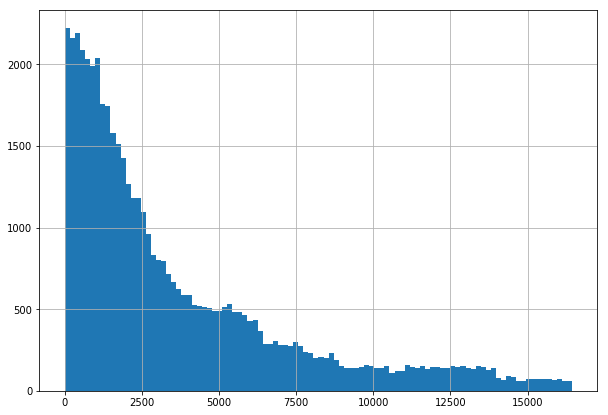

In [67]:
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

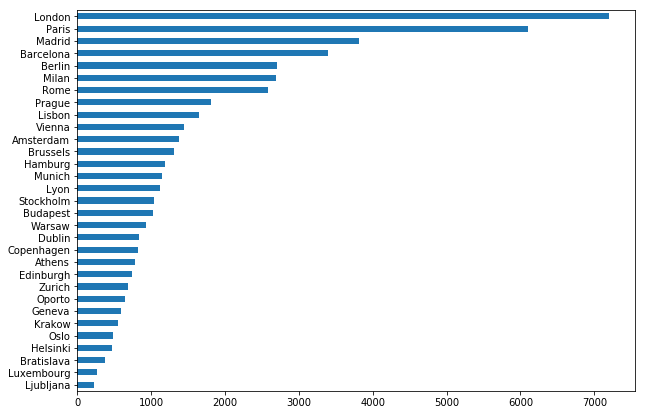

In [68]:
data['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

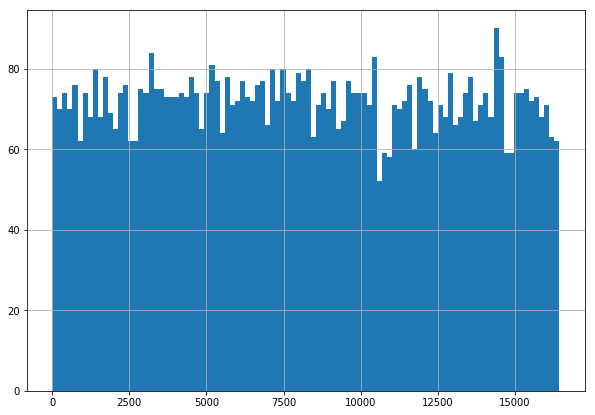

In [69]:
data['Ranking'][data['City'] =='London'].hist(bins=100)

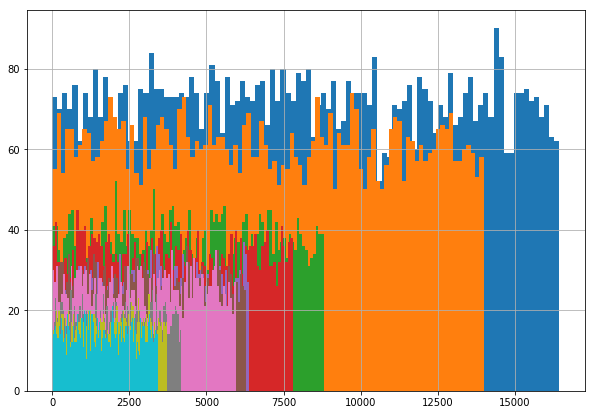

In [70]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


In [71]:
# Нормализовать переменную с целью подведения под одну шкалу ранг и создать новый признак
# preprocessing.normalize
# MinMaxScaler

df = data.groupby('City')['Ranking']
min_, max_ = df.transform('min'), df.transform('max')
data['Ranking_norm'] = (data['Ranking'] - min_) / (max_ - min_)

In [72]:
data.sample(5)

,City,Cuisine Style,Ranking,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,review_date,date_delta,days_ago,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,rest_number_city,Ranking_norm
8412,Lisbon,[unknown],2944.0,0.0,8672779,0,0.0,1,1,1,0,1,0,0,0,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1647,0.791981
15019,Brussels,[unknown],2489.0,20.0,1228728,1,4.0,0,1,1,0,1,0,0,0,0,"[2017-04-26, 2014-02-24]",1157,2828,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1314,0.827839
27816,Hamburg,[unknown],1441.0,2.0,1343402,1,4.5,0,1,1,0,1,0,0,0,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1186,0.526316
8965,Paris,[unknown],12287.0,12.0,8305152,0,0.0,0,1,1,0,1,0,0,0,0,[2015-09-04],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6108,0.878495
27579,Prague,[unknown],3140.0,3.0,5877629,1,4.0,0,1,1,0,1,0,0,0,0,[2015-09-29],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1816,0.749642


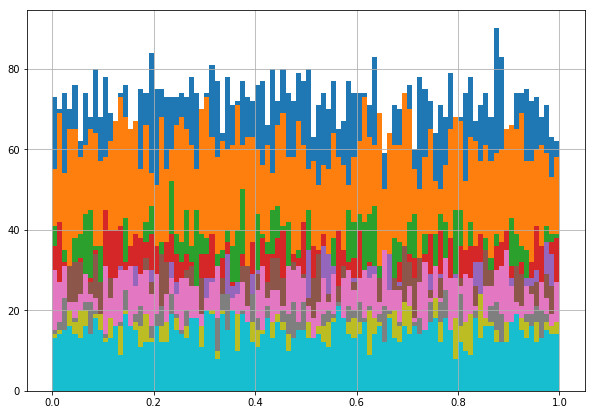

In [73]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking_norm'][data['City'] == x].hist(bins=100)
plt.show()

#### Number of Reviews

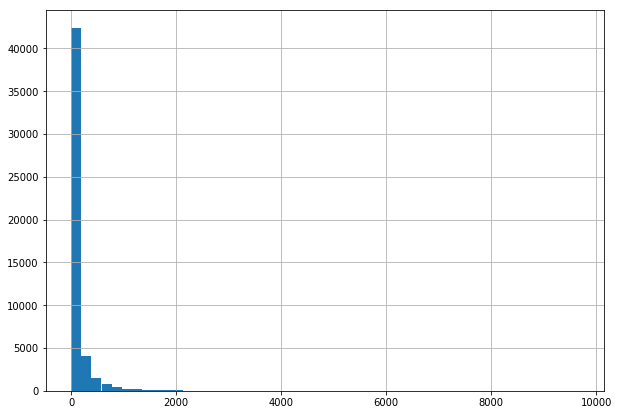

In [74]:
data['Number of Reviews'].hist(bins=50)

In [75]:
data['Number of Reviews'].describe()

count    50000.000000
mean       116.528560
std        286.163568
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

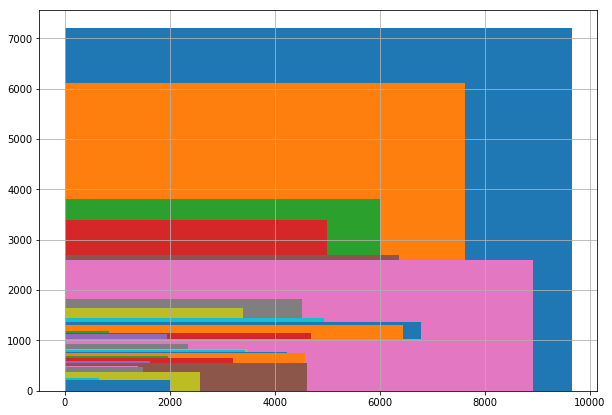

In [76]:
# посмотрим на топ 10 городов по количеству отзывов
for x in (data['City'].value_counts())[0:31].index:
    data['Number of Reviews'][data['City'] == x].hist(bins=1)
plt.show()

In [77]:
data.groupby('City')['Number of Reviews'].agg(['min','mean', 'median', 'max'])

,min,mean,median,max
City,,,,
Amsterdam,0.0,141.290087,40.0,6777.0
Athens,0.0,87.349227,18.0,4234.0
Barcelona,0.0,126.506627,29.0,4996.0
Berlin,0.0,57.671349,14.0,2572.0
Bratislava,0.0,43.950000,8.0,2578.0
Brussels,0.0,86.745053,23.0,6437.0
Budapest,0.0,145.351616,19.0,7575.0
Copenhagen,0.0,89.974359,28.0,3426.0
Dublin,0.0,146.937799,37.0,3491.0


In [78]:
# Создадим функцию для определения границ выбросов.
def find_IQR(data, column):
    perc_25 = data[column].quantile(0.25, interpolation="midpoint")
    median = data[column].median()
    perc_75 = data[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    b = perc_75 + 1.5*IQR
    
    print('Q1: {}'.format(perc_25), 'median: {}'.format(median), 
          'Q3: {}'.format(perc_75), 'IQR: {}'.format(IQR),
          'Граница выбросов: [{a},{b}]'.format(a=perc_25 - 1.5*IQR, b=perc_75 + 1.5*IQR), 
          '% попадающий за границу выбросов: {}'.format(((len(data[data[column] > b]))/len(data[column]))*100), 
          sep='\n') 

In [79]:
# find_IQR(data, 'Number of Reviews')

In [80]:
for x in (data['City'].value_counts())[0:10].index:
    print("\n", x)
    find_IQR(data[data['City'] == x], 'Number of Reviews')
    


 London
Q1: 7.0
median: 32.0
Q3: 121.0
IQR: 114.0
Граница выбросов: [-164.0,292.0]
% попадающий за границу выбросов: 10.9968024468233

 Paris
Q1: 9.0
median: 40.0
Q3: 123.0
IQR: 114.0
Граница выбросов: [-162.0,294.0]
% попадающий за границу выбросов: 9.479371316306482

 Madrid
Q1: 7.0
median: 23.0
Q3: 82.0
IQR: 75.0
Граница выбросов: [-105.5,194.5]
% попадающий за границу выбросов: 12.247574088644113

 Barcelona
Q1: 7.0
median: 29.0
Q3: 117.5
IQR: 110.5
Граница выбросов: [-158.75,283.25]
% попадающий за границу выбросов: 11.310751104565538

 Berlin
Q1: 4.0
median: 14.0
Q3: 45.0
IQR: 41.0
Граница выбросов: [-57.5,106.5]
% попадающий за границу выбросов: 11.79297597042514

 Milan
Q1: 9.0
median: 42.0
Q3: 189.5
IQR: 180.5
Граница выбросов: [-261.75,460.25]
% попадающий за границу выбросов: 9.35412026726058

 Rome
Q1: 31.0
median: 112.0
Q3: 338.0
IQR: 307.0
Граница выбросов: [-429.5,798.5]
% попадающий за границу выбросов: 9.385863267670915

 Prague
Q1: 4.0
median: 15.0
Q3: 64.0
IQR: 60.0

In [81]:
#  По все городам процент выбросов достаточно большой почти 10% и выше

# предлагаю нормализовать, сгруппировав по городам предварительно

df = data.groupby('City')['Number of Reviews']
min_, max_ = df.transform('min'), df.transform('max')
data['Number_Reviews_norm'] = (data['Number of Reviews'] - min_) / (max_ - min_)

In [82]:
data.sample(5)

,City,Cuisine Style,Ranking,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,review_date,date_delta,days_ago,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,rest_number_city,Ranking_norm,Number_Reviews_norm
47122,Milan,[unknown],1691.0,114.0,4166865,1,4.0,0,1,1,0,1,0,0,0,0,"[2017-10-07, 2017-01-14]",266,1773,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2694,0.269366,0.017925
41296,Paris,"[Italian, Pizza, European, Vegetarian Friendly]",1102.0,476.0,2345466,1,4.0,0,0,0,0,4,1,0,1,0,"[2017-12-31, 2017-11-11]",50,1472,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6108,0.078595,0.062451
46527,Paris,"[Italian, Pizza, Vegetarian Friendly]",6010.0,454.0,3204147,1,3.5,0,0,0,0,3,1,0,1,0,"[2017-12-11, 2017-09-26]",76,1518,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6108,0.429593,0.059564
16781,Rome,"[Pizza, Vegetarian Friendly]",1280.0,372.0,4260432,1,4.0,0,0,0,0,2,1,0,1,0,"[2016-10-26, 2015-08-28]",425,2278,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2589,0.215066,0.041671
48801,Brussels,"[Mediterranean, Barbecue, Sushi, Asian]",1656.0,25.0,3365369,1,4.0,0,0,0,0,4,0,0,1,0,"[2017-03-21, 2016-10-21]",151,1858,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1314,0.550450,0.003884


In [83]:
data.sample(5)

,City,Cuisine Style,Ranking,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,review_date,date_delta,days_ago,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,rest_number_city,Ranking_norm,Number_Reviews_norm
14009,Warsaw,[unknown],1032.0,0.0,13289876,1,5.0,1,1,1,0,1,0,0,0,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,925,0.478867,0.000000
24401,Budapest,"[European, Hungarian]",1521.0,14.0,12405781,1,4.0,0,0,0,0,2,0,1,0,0,"[2017-08-27, 2017-08-18]",9,1557,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1021,0.623206,0.001848
24469,Barcelona,[unknown],7580.0,5.0,10339532,1,2.5,0,1,1,0,1,0,0,0,0,[2016-05-22],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3395,0.972276,0.001001
45587,London,"[Indian, Asian]",9570.0,30.0,2537935,1,4.0,0,0,0,0,2,0,0,1,0,"[2017-11-01, 2017-12-13]",42,1440,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7193,0.581950,0.003106
3750,Paris,[African],1540.0,32.0,11978005,0,0.0,0,0,0,0,1,0,0,1,0,"[2017-11-01, 2017-10-18]",14,1496,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6108,0.109919,0.004198


### Посмотрим распределение целевой переменной

In [84]:
# df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

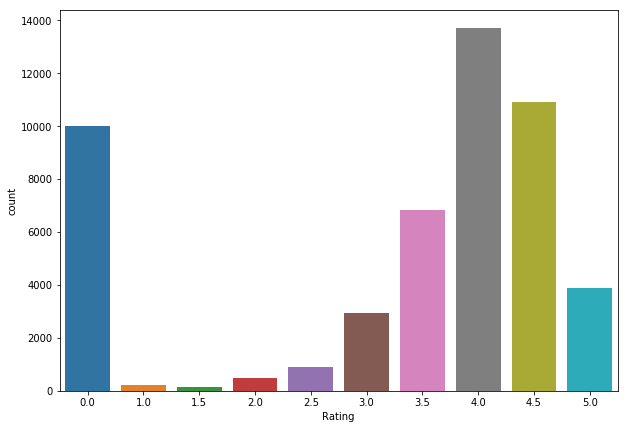

In [85]:
sns.countplot(x='Rating', data=data, label='Rating')

### Посмотрим распределение целевой переменной относительно признака

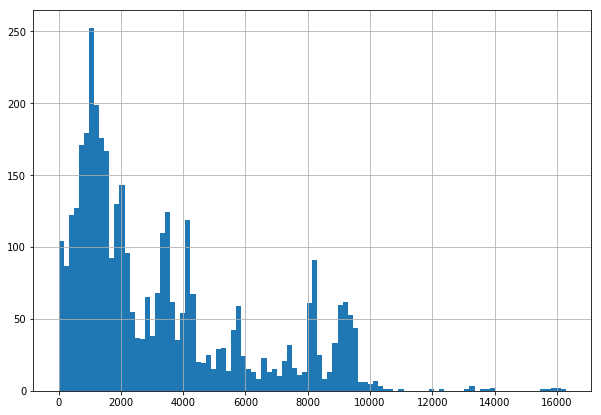

In [86]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

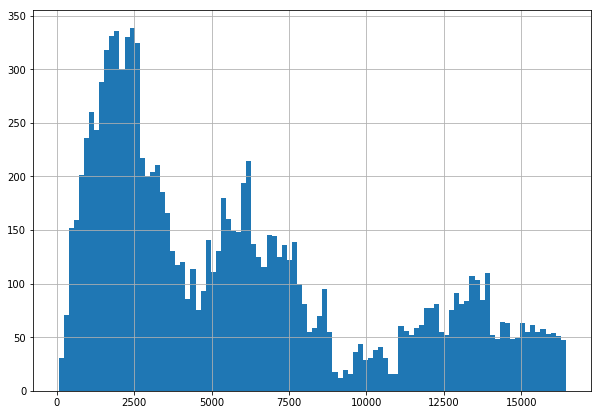

In [87]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

In [88]:
data.sample(5)

,City,Cuisine Style,Ranking,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,review_date,date_delta,days_ago,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,rest_number_city,Ranking_norm,Number_Reviews_norm
32409,Paris,[unknown],13473.0,7.0,6697362,1,2.0,0,1,1,0,1,0,0,0,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6108,0.963313,0.000918
11412,London,"[European, Wine Bar, Gluten Free Options]",4446.0,151.0,1989577,1,4.0,0,0,0,0,3,1,0,1,0,"[2017-08-10, 2017-07-12]",29,1594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7193,0.270328,0.015631
1198,Barcelona,"[Mediterranean, Vegan Options]",6622.0,35.0,7215770,0,0.0,0,0,0,0,2,1,0,1,0,"[2017-10-21, 2016-10-31]",355,1848,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3395,0.849313,0.007006
49278,London,"[Bar, British, Pub]",6061.0,85.0,2507971,1,3.5,0,0,0,0,3,0,0,1,0,"[2017-11-26, 2017-09-03]",84,1541,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7193,0.368546,0.008799
10696,Milan,"[Italian, Seafood, Mediterranean]",2091.0,103.0,2701946,1,4.5,0,0,0,0,3,0,0,1,0,"[2014-11-28, 2014-06-26]",155,2706,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2694,0.333121,0.016195


### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [89]:
# plt.rcParams['figure.figsize'] = (15,10)
# sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [90]:
#### ghjdthbnm

from itertools import combinations

def get_corr(dataframe, name):
    digit_columns = dataframe.select_dtypes(include=['int64', 'float64']).columns
    combinations_all = list(combinations(digit_columns, 2))
    corr = {}
    
    for c in combinations_all:
        col1 = dataframe[c[0]]
        col2 = dataframe[c[1]]
        corr[c] = col1.corr(other=col2)

    idx = pd.MultiIndex.from_tuples(corr.keys(), names=['A', 'B'])
    #corr = pd.Series(corr, index = idx).sort_values()
    corr = pd.DataFrame(list(corr.values()), index=idx,
                        columns=[name]).sort_values(by=name)
    return corr

corr = get_corr(data.drop(['sample'], axis=1), 'general')

In [91]:
#### fhkfjyh,hjv


perc25 = (abs(corr.max()) + abs(corr.min())) * 0.125  # ((abs(a) + abs(b)) / 2) * 0.25
display(corr[(corr < -perc25) | (corr > perc25)].dropna())

general
A                 B                            
healthy_options   Ranking_norm        -0.561238
Number_of_Cuisine Ranking_norm        -0.543634
Number of Reviews Ranking_norm        -0.407322
Ranking_norm      Number_Reviews_norm -0.396786
ID_TA             days_ago            -0.339539
Ranking           Number_of_Cuisine   -0.322408
                  healthy_options     -0.305387
Number of Reviews ID_TA               -0.289950
ID_TA             Number_Reviews_norm -0.278615
Ranking           Number_Reviews_norm -0.262758
                  Number of Reviews   -0.223156
ID_TA             Number_of_Cuisine   -0.220469
days_ago          Ranking_norm        -0.215423
ID_TA             date_delta          -0.195935
                  healthy_options     -0.192192
healthy_options   days_ago             0.192327
Number_of_Cuisine days_ago             0.221582
healthy_options   Number_Reviews_norm  0.353849
Number of Reviews healthy_options      0.378957
Number_of_Cuisine Number_Reviews_norm  0.391518
Number of Reviews Number_of_Cuisine    0.409403
date_delta        days_ago             0.567050
Ranking           Ranking_norm         0.570836
Number_of_Cuisine healthy_options      0.703427
Ranking           rest_number_city     0.709012
Number of Reviews Number_Reviews_norm  0.808807

In [92]:
# corr

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

In [93]:
# data.sample(5)

In [94]:
# data.columns

In [95]:
#Удаляем все лишнее, чтоб модель сработала:


# data.drop(['Restaurant_id'], axis=1, inplace=True)
data.drop(['City'], axis=1, inplace=True)
data.drop(['Cuisine Style'], axis=1, inplace=True)
# data.drop(['ID_TA'], axis=1, inplace=True)
# data.drop(['Ranking'], axis=1, inplace=True)
# data.drop(['Rating'], axis=1, inplace=True)
data.drop(['review_date'], axis=1, inplace=True)

In [96]:
data.sample(5)

,Ranking,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,date_delta,days_ago,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,rest_number_city,Ranking_norm,Number_Reviews_norm
36254,554.0,263.0,1111383,1,4.0,0,0,0,0,4,1,0,1,0,35,1483,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1372,0.169997,0.038808
43341,3081.0,271.0,2361209,1,4.0,0,0,0,0,5,1,0,1,0,21,1475,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6108,0.220124,0.035555
35839,680.0,32.0,11621253,1,4.5,0,0,0,0,5,1,0,1,0,9,1498,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2705,0.106436,0.012442
49227,7261.0,174.0,2535476,1,3.5,0,0,0,0,3,0,0,1,0,13,1429,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6108,0.519059,0.022829
16979,1266.0,135.0,1993139,1,4.5,0,0,0,0,5,1,0,1,0,80,1608,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3395,0.161853,0.027022


# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [97]:
# на всякий случай, заново подгружаем данные
# df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
# df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
# df_train['sample'] = 1 # помечаем где у нас трейн
# df_test['sample'] = 0 # помечаем где у нас тест
# df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

# data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
# data.info()

In [98]:
#  data.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)

In [99]:
# def preproc_data(df_input):
#     '''includes several functions to pre-process the predictor data.'''
    
#     df_output = df_input.copy()
    
#     # ################### 1. Предобработка ############################################################## 
#     # убираем не нужные для модели признаки
#     df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
#     # ################### 2. NAN ############################################################## 
#     # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
#     df_output['Number of Reviews'].fillna(0, inplace=True)
#     # тут ваш код по обработке NAN
#     # ....
    
    
#     # ################### 3. Encoding ############################################################## 
#     # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
#     df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
#     # тут ваш код не Encoding фитчей
#     # ....
    
    
#     # ################### 4. Feature Engineering ####################################################
#     # тут ваш код не генерацию новых фитчей
#     # ....
    
    
#     # ################### 5. Clean #################################################### 
#     # убираем признаки которые еще не успели обработать, 
#     # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
#     object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
#     df_output.drop(object_columns, axis = 1, inplace=True)
    
#     return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [100]:
# df_preproc = preproc_data(data)
# df_preproc.sample(10)

In [101]:
# df_preproc.info()

In [102]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [103]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [104]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 49), (40000, 49), (40000, 48), (32000, 48), (8000, 48))

# Model 
Сам ML

In [105]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [106]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [107]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [108]:
# Округлим рейтинг, кратный 0.5 
def round_rating_pred(rating_pred):
    if rating_pred <= 0.25:
        return 0.0
    if rating_pred <= 0.75:
        return 0.5
    if rating_pred <= 1.25:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0


# 
for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])

In [109]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1638125


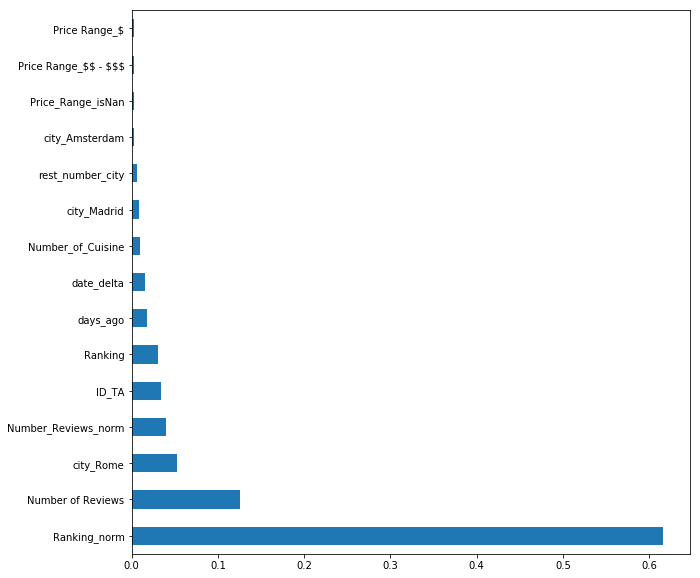

In [110]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [111]:
test_data.sample(10)

,Ranking,Number of Reviews,ID_TA,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNan,Price_Range_isNan,Reviews_isNan,Number_of_Cuisine,healthy_options,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,date_delta,days_ago,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,rest_number_city,Ranking_norm,Number_Reviews_norm
1799,6302.0,107.0,3346373,0.0,0,0,0,0,6,0,0,1,0,4,1446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7193,0.383203,0.011077
822,3284.0,49.0,4338947,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2694,0.523271,0.007704
2948,2042.0,224.0,10430922,0.0,0,0,0,0,5,1,0,1,0,11,1449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7193,0.124126,0.023188
2965,597.0,74.0,720429,0.0,0,0,0,0,6,1,0,1,0,11,1426,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,745,0.337677,0.016203
2691,313.0,2377.0,1603440,0.0,0,0,0,0,4,1,0,1,0,31,1509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2589,0.052463,0.266271
6446,3850.0,83.0,4070199,0.0,0,0,0,0,1,0,0,1,0,1068,2960,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2589,0.647217,0.009298
8739,1637.0,1.0,4313262,0.0,1,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,925,0.759870,0.000424
3346,2513.0,7.0,7258758,0.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1314,0.835831,0.001087
1458,5361.0,66.0,2295254,0.0,0,0,0,0,2,0,0,1,0,259,1743,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6108,0.383180,0.008659
9567,2168.0,237.0,718171,0.0,0,0,0,0,4,1,0,1,0,10,1431,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6108,0.154831,0.031094


In [112]:
test_data = test_data.drop(['Rating'], axis=1)

In [113]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [114]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [115]:
predict_submission = list(map(round_rating_pred, predict_submission))

In [116]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
